In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
def epoch(ts):
    pattern = '%d-%m-%Y'
    epochtime = int(time.mktime(time.strptime(ts, pattern)))
    
    return epochtime

def time_log(line):
    start = line.rfind("(")+1
    middle = line.rfind(",")
    end = line.rfind(")")
    t1 = epoch(line[start:middle])
    t2 = epoch(line[middle+1:end])
    tr = [t1,t2]
    
    return tr

def time_diff(ts, te):
    
    t1_y = int(ts.split("-")[0])
    t1_m = int(ts.split("-")[1])
    t1_d = int(ts.split("-")[2])
        
    #yyyy-mm-dd
    
    t2_y = int(te.split("-")[0])
    t2_m = int(te.split("-")[1])
    t2_d = int(te.split("-")[2])   
    
    d1 = date(t1_y, t1_m, t1_d)
    d2 = date(t2_y, t2_m, t2_d)
    delta = d1 - d2
    time_diff = abs(delta.days)
    
    return time_diff

In [3]:
def real_sol():
    sol ={}
    l1 = ['flood,Colorado,2013-09-09', 'blizzard,New York,2014-02-11', 'hurricane,North Carolina,2014-07-01']
    l2 = ['tornado,Oklahoma,2013-05-20', 'blizzard,Massachusetts,2014-02-06', 'earthquake,California,2014-08-24']    
    l3 = ['hurricane,Florida,2013-06-09', 'earthquake,California,2014-03-17', 'blizzard,New York,2014-11-13']
    sol['pos1,pos7,pos6'] = l1
    sol['pos4,pos9,pos5'] = l2
    sol['pos2,pos3,pos8'] = l3
    
    return sol
    

def each_effort(log_dict, algo, data, xkey, time, nd_list, location_list, nd_time, sol):
    
    # log effort part
    
    if(len(log_dict['operations']['x'])== 0):
        log_dict['operations']['x'].append(1)
    else:
        log_dict['operations']['x'].append(log_dict['operations']['x'][-1]+1)
    
    log_dict['time_elapsed']['x'].append(time)     
    
    if(len(log_dict[xkey]['x'])!=0):
        log_dict[xkey]['x'].append(log_dict[xkey]['x'][-1]+1)
    else:
        log_dict[xkey]['x'].append(1)
    
    
    # log results part
    
    ylist = ['nd_precision', 'location_precision', 'nd_recall', 'location_recall','nd_time_error']
    
    nd_sol = [x.split(',')[0] for x in sol]
    location_sol = [x.split(',')[1] for x in sol]
    ndtime_sol = [x.split(',')[2] for x in sol]
    # log result part
    
    nd_p = 0.000
    nd_r = 0.000    
    if(len(nd_list)!=0):
        nd_corr = 0
        for nd in nd_list:
            if(nd in nd_sol):
                nd_corr += 1
        
        nd_p = float(nd_corr)/len(nd_list)
        nd_r = float(nd_corr)/3.0      
        
    
    log_dict[xkey]['nd_precision'].append(nd_p)
    log_dict['operations']['nd_precision'].append(nd_p)
    log_dict['time_elapsed']['nd_precision'].append(nd_p)
    log_dict[xkey]['nd_recall'].append(nd_r)
    log_dict['operations']['nd_recall'].append(nd_r)
    log_dict['time_elapsed']['nd_recall'].append(nd_r)      
    
    
    location_p = 0.000
    location_r = 0.000
    if(len(location_list)!=0):
        location_corr = 0
        for location in location_list:
            if(location in location_sol):
                location_corr += 1
        
        location_p = float(location_corr)/len(location_list)
        location_r = float(location_corr)/len(location_list)
    
    log_dict[xkey]['location_precision'].append(location_p)
    log_dict['operations']['location_precision'].append(location_p)
    log_dict['time_elapsed']['location_precision'].append(location_p)
    log_dict[xkey]['location_recall'].append(location_r)
    log_dict['operations']['location_recall'].append(location_r)
    log_dict['time_elapsed']['location_recall'].append(location_r)     
    
    time_err = 0.000
    if(len(nd_time)!=0):
        for time in nd_time:
            time_err_cur = 1000000
            for t_sol in ndtime_sol:
                time_err_cur_sol = time_diff(time, t_sol)
                if(time_err_cur_sol < time_err_cur):
                    time_err_cur = time_err_cur_sol
            time_err += time_err_cur
    
    log_dict[xkey]['nd_time_error'].append(time_err)
    log_dict['operations']['nd_time_error'].append(time_err)
    log_dict['time_elapsed']['nd_time_error'].append(time_err)     
    
    return log_dict


def each_log(logDir, logFile, real_sol):
    
    fieldlist = ['query', 'slider', 'ZoomLevel', 'MouseDrag', 'checking_tweet',
                 'checking_filter', 'time_elapsed', 'operations']    
    ylist = ['nd_precision', 'location_precision', 'nd_recall', 'location_recall','nd_time_error']
    
    nds = []
    locations = [] 
    ndtimes = []
    
    log_dict = {} # save log infor
    
    for field in fieldlist:
        log_dict[field] = {}
        log_dict[field]['x'] = []
        for y in ylist:
            log_dict[field][y] = []
            
    log = logDir + logFile
    
    with open(log, "r") as f:
        i = 0
        ts = 0
        tsq = 0
        tq = 0
        algo = 'good'
        data = 'good'
        for line in f:
            i += 1
            line_split = line.split('\t')
            if('START' in line_split[1]):
                algo = line_split[2]
                data = line_split[-1][:-1]
                log_dict['algo']= algo
                log_dict['data']= data
                sol = real_sol[data]
                ts = float(line_split[0])/1000
                
            elif('Query_Execution' in line_split[1]):
                teq = float(line_split[0])/1000
                tq += (teq - tsq)
            
            elif('query' in line_split[1]):
                xkey = 'query'
                tsq = float(line_split[0])/1000
                time_com = tsq - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)
                    
            elif('slider' in line_split[1]):
                xkey = 'slider'
                time_com = float(line_split[0])/1000 - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)
                
            elif('ZoomLevel' in line_split[1]):
                xkey = 'ZoomLevel'
                time_com = float(line_split[0])/1000 - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)                
            
            elif('MouseDrag' in line_split[1]):
                xkey = 'MouseDrag'
                time_com = float(line_split[0])/1000 - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol) 
            
            elif('clicking_tweet' in line_split[1]):
                xkey = 'checking_tweet'
                time_com = float(line_split[0])/1000 - ts - tq
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol) 
                                    
            elif(('clicking_bbox' in line_split[1]) or ('adding_filter' in line_split[1])
                 or ('removing_filter' in line_split[1])):
                xkey = 'checking_filter'
                time_com = float(line_split[0])/1000 - ts - tq                
                log_dict = each_effort(log_dict, algo, data, xkey, time_com, nds, locations, ndtimes, sol)   
            
            elif('final_answer' in line_split[1]):
                nds.append(line_split[3])
                ndtimes.append(line_split[5])
                locations.append(line_split[7][:-1])
                
        f.close()
    
    return log_dict

In [4]:
log_dir = "experiment_logs/"
filename = 'logs_4_baseline.txt'
rs = real_sol()
one_dict = each_log(log_dir, filename, rs)

In [5]:
def total_log_initial():
    fieldlist = ['query', 'slider', 'ZoomLevel', 'MouseDrag','checking_tweet',
                'checking_filter','adjusting_filter', 'time_elapsed', 'operations']
    
    ylist = ['nd_precision', 'location_precision', 'nd_recall', 'location_recall','nd_time_error']
    
    algolist = ['baseline','kmeans','filters']
    datalist = ['pos1,pos7,pos6','pos4,pos9,pos5','pos2,pos3,pos8']
    
    keylist = []
    for algo in algolist:
        for data in datalist:
            keylist.append((algo, data))
    
    total_dict = {}
    
    for field in fieldlist:
        total_dict[field] = {} 
        total_dict[field]['x'] = {}
        for algo in algolist:
            for key in keylist:             
                total_dict[field]['x'][key] = []
        for y in ylist:
            total_dict[field][y] = {}
            for key in keylist:            
                total_dict[field][y][key] = []

    return total_dict

def total_log_writing(total_dict, log_dict, norm):
    fieldlist = ['query', 'slider', 'ZoomLevel', 'MouseDrag', 'checking_tweet',
                'checking_filter','time_elapsed', 'operations']
    
    ylist = ['nd_precision', 'location_precision', 'nd_recall', 'location_recall','nd_time_error']
    
    algo = log_dict['algo']
    data = log_dict['data']
    key = (algo, data)
    
    for f in fieldlist:
        unnorm_x = log_dict[f]['x']
        if(len(unnorm_x)!=0):
            if (f=='time_elapsed' and norm=='Yes'):
                norm_x = [(float(ele))/float(max(unnorm_x)) for ele in unnorm_x]
                total_dict[f]['x'][key].append(norm_x)
            else:
                total_dict[f]['x'][key].append(unnorm_x)
        
        for y in ylist:            
            total_dict[f][y][key].append(log_dict[f][y])
    
    return total_dict

In [6]:
def interp(X, Y, long_X):
    xs = set(X)
    xp = list(long_X - xs) #Note long_X is Set
    y_eval = [float(0.000)]*len(Y)
    if(len(Y)!= 0):
        yp = np.interp(xp, X, Y)
        y_eval = [yv for _,yv in sorted(zip(X,Y)+zip(xp, yp))]
    
    return y_eval

def plot_algo(total_dict, filename):
    fieldlist = ['query', 'slider', 'ZoomLevel', 'MouseDrag', 'checking_tweet',
                 'checking_filter', 'time_elapsed', 'operations']
    ylist = ['nd_precision', 'location_precision', 'nd_recall', 'location_recall','nd_time_error']
    
    algolist = ['baseline','kmeans','filters']
    datalist = ['pos1,pos7,pos6','pos4,pos9,pos5','pos2,pos3,pos8']
    
    color_algo = ['blue','green','red']
    
    pp = PdfPages(filename)
    k = 1
    for f in fieldlist:
        for y in ylist:
            fig = plt.figure(k)
            ax = plt.axes()
            ax.grid(True)
            for i in range(len(algolist)):
                algo = algolist[i]
                keylist = []
                for data in datalist:
                    keylist.append((algo, data))              
                unflatten_x = []
                unflatten_y = []
                lx = []
                ly = []
                for key in keylist:
                    lx = total_dict[f]['x'][key]
                    ly = total_dict[f][y][key]
                    unflatten_x += lx
                    unflatten_y += ly

                unflatten_x = filter(None, unflatten_x)
                unflatten_y = filter(None, unflatten_y)  #remove empty nested-list 
                
                if (len(unflatten_x)!=0):
                    x_plot_set = set(reduce(lambda x1,x2: x1+x2,unflatten_x))
                    x_plot = list(x_plot_set)
                    x_plot.sort()
                    y_total = []

                    for j in range(len(unflatten_x)):
                        y_total_current = interp(unflatten_x[j], unflatten_y[j], x_plot_set)
                        y_total.append(y_total_current)

                    if(len(x_plot)!=0):
                        ym = np.mean(y_total, axis = 0, dtype = float)
                        ys = np.std(y_total, axis= 0, dtype=float)
                        yl = ym - ys
                        yu = ym + ys

                        plt.plot(x_plot, ym, linestyle='-', color=color_algo[i], label=algo+'_mean')
                        plt.fill_between(x_plot, yl, yu, alpha=0.1, edgecolor='', facecolor=color_algo[i], linewidth=0.0) 
            plt.title(f + ' VS '+ y)
            plt.xlabel(f)
            plt.ylabel(y)
            plt.legend()
            k+= 1
            
            #plt.savefig(f+"_"+y, format='eps')
            plt.savefig(pp, format='pdf')
            plt.show()
    
    pp.close()
    print k

### In each plot, solid line and dot line are used for mean and mean +/- standard deviation
### Blue is for baseline algorithm,  green is for kmeans, and red is for filters.
### Also, note that all completion time is squashed into (0.0, 1.0]

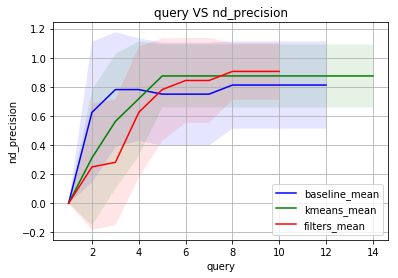

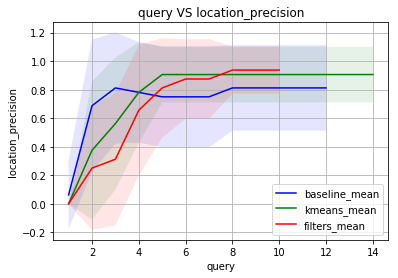

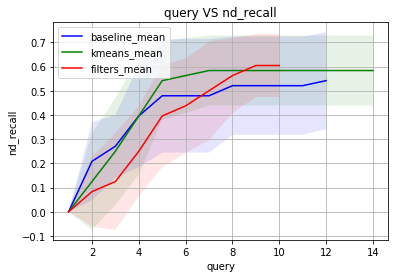

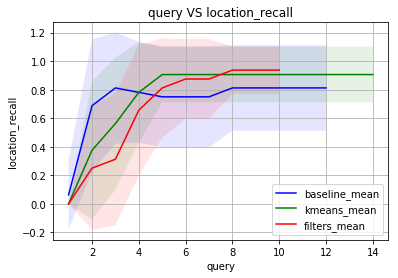

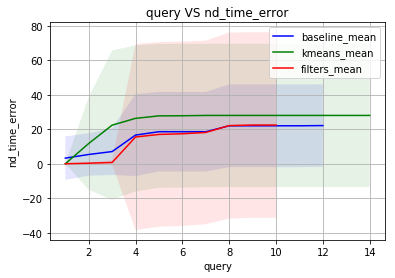

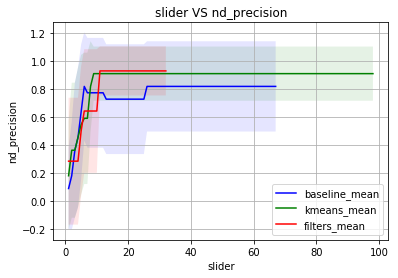

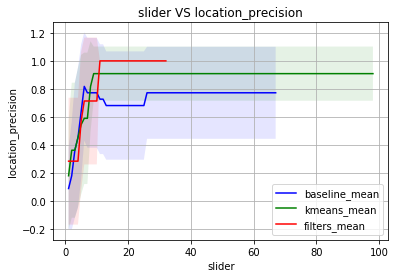

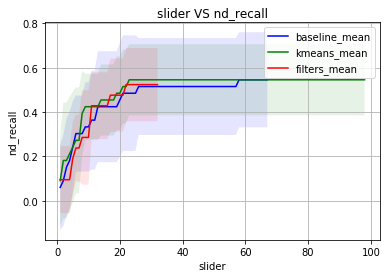

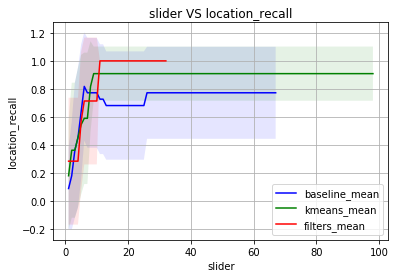

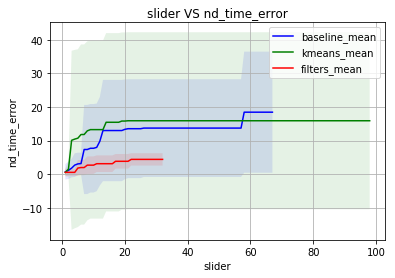

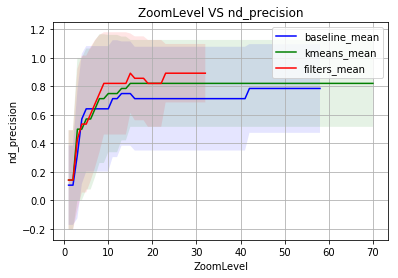

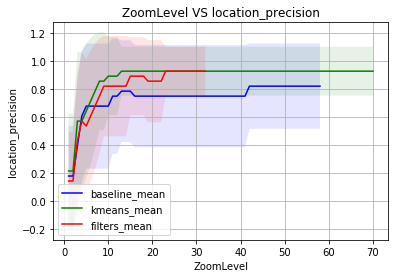

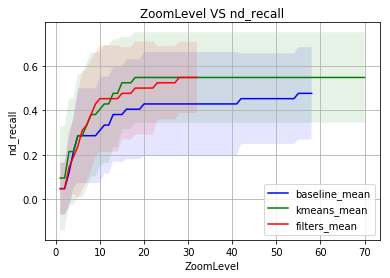

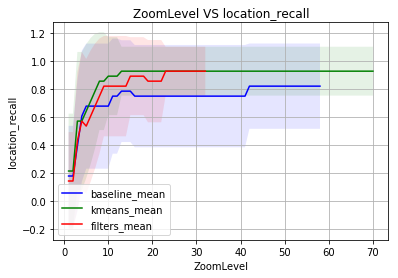

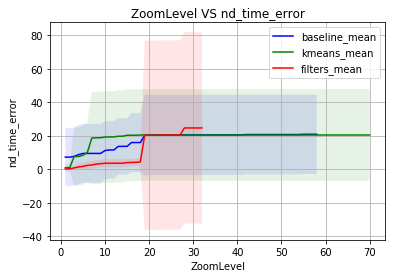

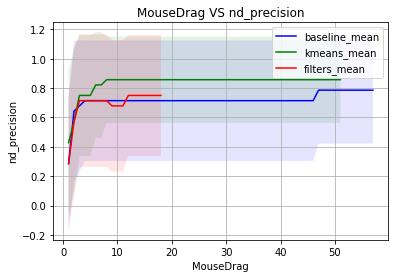

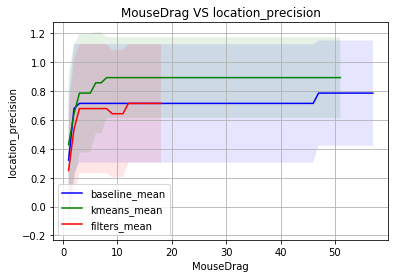

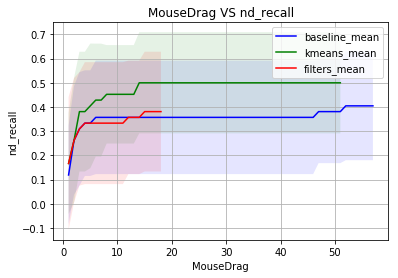

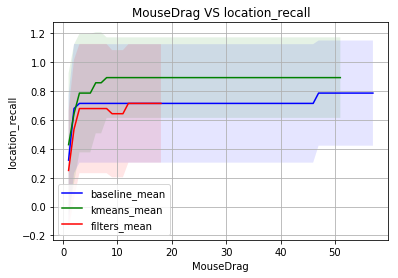

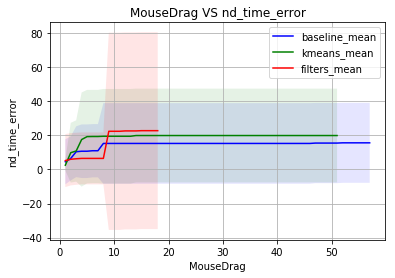

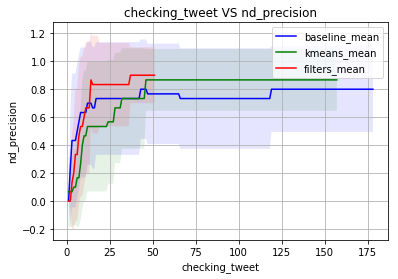

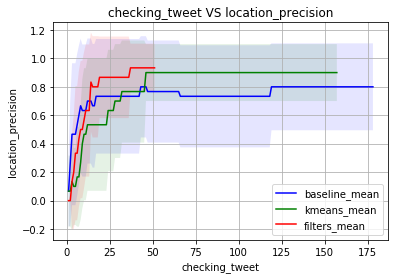

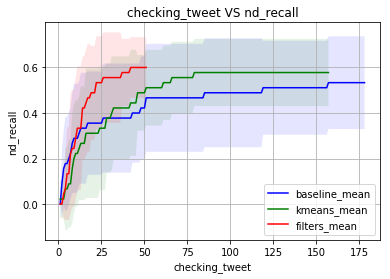

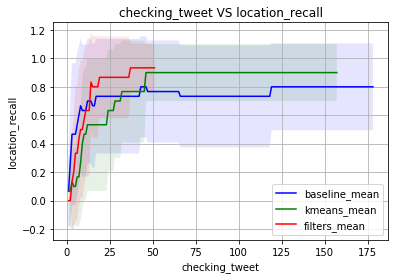

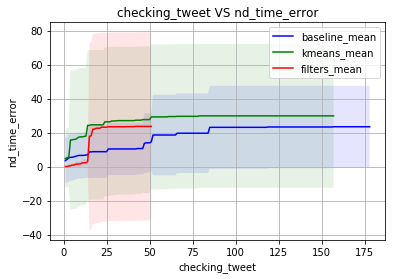

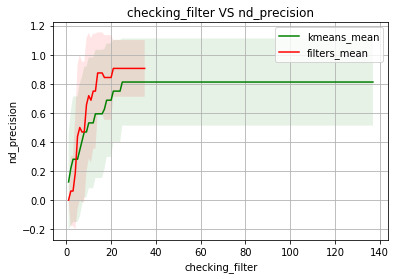

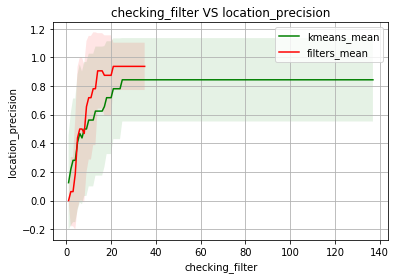

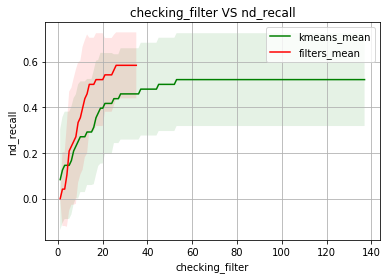

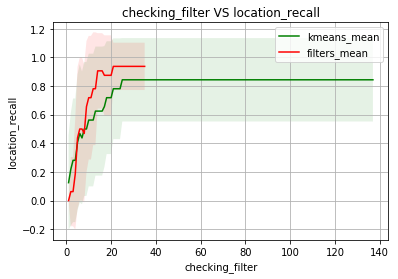

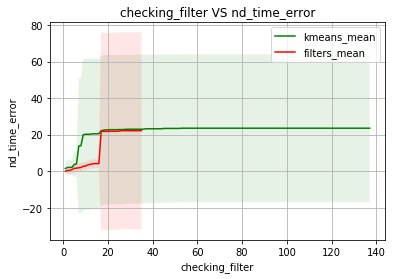

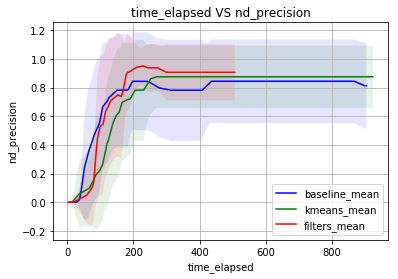

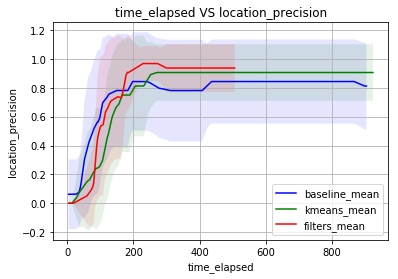

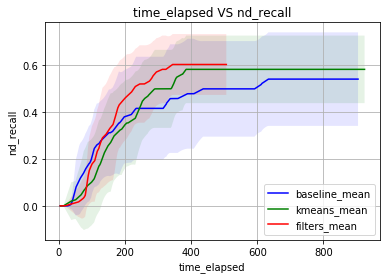

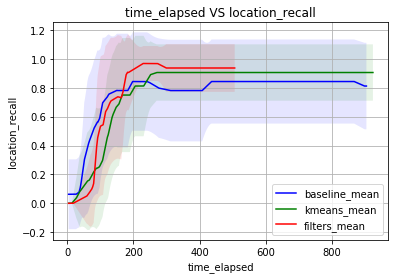

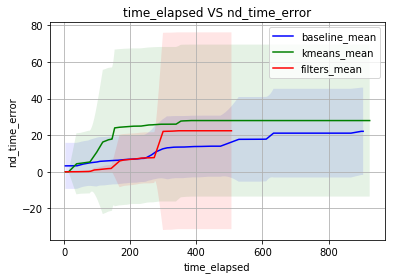

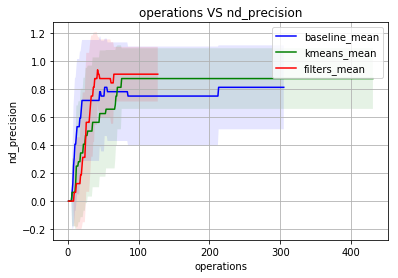

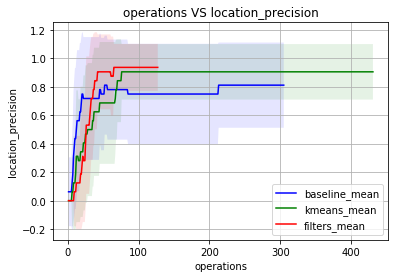

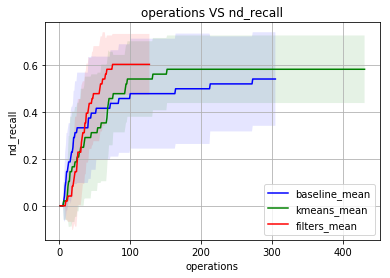

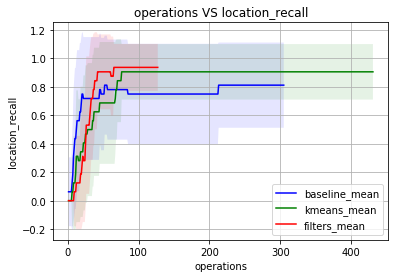

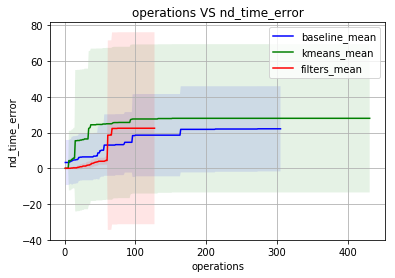

41


In [7]:
log_dir = "experiment_logs/"

total_dict = total_log_initial()
rs = real_sol()
for filename in os.listdir(log_dir):
    one_dict = each_log(log_dir, filename, rs)
    #total_dict = total_log_writing(total_dict, one_dict, 'Yes')
    total_dict = total_log_writing(total_dict, one_dict, 'No')

pdfname = "results.pdf"  
plot_algo(total_dict, pdfname)